 # EDS Venus/Sentinel-2 Building Prediction Over Denver Site
 
 This notebook demonstrates querying the STAC API for a Venus chip using an ROI, saving RGB PNG and multispectral Geotiffs, and then using this imagery to train a simple (not deep) model for building/not-building pixel level prediction.


## Environment Setup 

Refer to README.md for environment setup. 

### Import and Init Env

In [ ]:
import os

# If using LightningAI, change the current working directory to the directory containing this notebook. 
REPO_DIR = "/teamspace/studios/this_studio/eda-bids-hackathon-prep/"  # Adjust as appropriate
if os.path.exists(REPO_DIR):
    os.chdir(os.path.join(REPO_DIR, "stac-notebooks"))

In [4]:
from dotenv import load_dotenv
import folium
from folium import raster_layers
import geopandas as gpd
from geopandas import GeoDataFrame
from glob import glob
from IPython.display import display
import io
import json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
from odc.stac import configure_rio, stac_load
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont
from pystac_client import Client
import pandas as pd
import rasterio
from rasterio.features import geometry_mask, geometry_window, rasterize
from rasterio.transform import from_origin
from rasterio.warp import transform_geom
import re
import requests
import rioxarray
from shapely.affinity import affine_transform
from shapely.geometry import box, shape
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from urllib.parse import urlparse

os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [5]:
# Uncomment to use dask cluster, just run once per session
# import dask.distributed
# client = dask.distributed.Client()
# configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
# display(client)

Authenticate with the STAC API, if you get an error check your credentials in `.env`

In [6]:
load_dotenv()  # take environment variables from .env.

def get_new_token():
    auth_server_url = os.getenv("EDS_AUTH_URL")
    client_id = os.getenv("EDS_CLIENT_ID")
    client_secret = os.getenv("EDS_SECRET")
    token_req_payload = {'grant_type': 'client_credentials'}

    token_response = requests.post(
        auth_server_url,
        data=token_req_payload,
        verify=False,
        allow_redirects=False,
        auth=(client_id, client_secret)
    )
    token_response.raise_for_status()

    tokens = json.loads(token_response.text)
    return tokens['access_token']

token = get_new_token()

catalog = Client.open(os.getenv("EDS_API_URL"), headers={
    "Authorization": f"bearer {token}"
})

/home/codespace/.local/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '2023-bids-hackathon-earthdaily.auth.us-east-1.amazoncognito.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


# Now select mission & catalogue
Edit the cell below to select between "S2" or "VENUS"

In [7]:
SATELLITE = "VENUS" # "S2" or "VENUS"

if SATELLITE == "S2":
    COLLECTION = "sentinel-2-l2a"
    BANDS = ("B04", "B03", "B02")

elif SATELLITE == "VENUS":
    COLLECTION = "venus-l2a"
    BANDS = ("red", "green", "blue", "nir08", "rededge", "yellow", "coastal") # ,

Setup location to save generated data

In [8]:
SITE = "DENVER" # site name in this tutorial
 
OUTPUTS_DIR = f"outputs_{SITE}_{SATELLITE}/" # location where the output files will be saved
if not os.path.exists(OUTPUTS_DIR):
    os.makedirs(OUTPUTS_DIR)

EMPTY_OUTPUTS_DIR = True # set to True to delete all files in OUTPUTS_DIR before running the notebook
if EMPTY_OUTPUTS_DIR:
    for f in glob(OUTPUTS_DIR + "*"):
        os.remove(f)

print(f"Using {SATELLITE} data from {catalog.description}")
print(f"Writing outputs to {OUTPUTS_DIR}")

Using VENUS data from stac-fastapi
Writing outputs to outputs_DENVER_VENUS/


In [9]:
# List collections to see what is available
for collection in catalog.get_collections():
    print(collection.id)

cbers4-mux
cropland-data-layer-us
earthdaily-simulated-cloudless-l2a-cog-edagro
landsat-c2l1
landsat-c2l2-sr
landsat-c2l2-st
sentinel-1-grd
sentinel-1-rtc
sentinel-2-l1c
sentinel-2-l2a
venus-l2a


Add ROI - from EDA UI or another tool (see GIF notebook)

In [10]:
ROI = {'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-104.982777, 39.788159],
    [-104.982777, 39.820865],
    [-104.912739, 39.820865],
    [-104.912739, 39.788159],
    [-104.982777, 39.788159]]]}}

In [11]:
def get_bounds_polygon_dict(polygon_dict: dict) -> tuple:
    gdf = gpd.GeoDataFrame.from_features([polygon_dict])
    polygon = gdf.geometry.iloc[0]
    bounds = polygon.bounds
    return bounds

bbox = get_bounds_polygon_dict(ROI)
print(bbox)

(-104.982777, 39.788159, -104.912739, 39.820865)


Set your remaining filter parameters and perform the query

In [12]:
# Set a start and end date
YEAR = 2023
start_date = f"{YEAR}-08-01"
end_date = f"{YEAR}-09-01"
max_clouds = 5 # the maximum cloud cover percentage. Note this is over the WHOLE image, not just the ROI

query = catalog.search(
    collections=[COLLECTION], 
    datetime=f"{start_date}/{end_date}",
    bbox=bbox,
    query={"eo:cloud_cover":{"lt":max_clouds}}, # uncomment to filter on cloud cover
)

items = list(query.get_items())
print(f"Found: {len(items):d} datasets")

/home/codespace/.python/current/lib/python3.10/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Found: 6 datasets


Just get a single item for this tutorial

In [13]:
item = items[-1]

Check the common names

In [14]:
common_names = sorted(list(set([i['common_name'] for i in item.properties['eo:bands']])))

common_names

['blue', 'coastal', 'green', 'nir08', 'nir09', 'red', 'rededge', 'yellow']

We now use `stac_load` to retrieve an [xarray](https://docs.xarray.dev/en/stable/) dataset using the `items` returned by the STAC query

We use dask to lazy load the data - view the dask dashboard to monitor processing. Note that running this cell multiple times

In [15]:
BANDS

('red', 'green', 'blue', 'nir08', 'rededge', 'yellow', 'coastal')

In [16]:
dataset = stac_load(
    [item],
    bands=BANDS,
    crs="epsg:3857", # since resolution is in metres, we need to use a projected CRS
    resolution=5, # the reoslution of the output image in metres
    # chunks={},  # <-- use Dask
    groupby="id",
    bbox=bbox,
)

display(dataset)

<xarray.Dataset>
Dimensions:      (y: 948, x: 1560, time: 1)
Coordinates:
  * y            (y) float64 4.84e+06 4.84e+06 4.84e+06 ... 4.835e+06 4.835e+06
  * x            (x) float64 -1.169e+07 -1.169e+07 ... -1.168e+07 -1.168e+07
    spatial_ref  int32 3857
  * time         (time) datetime64[ns] 2023-08-02T17:40:11
Data variables:
    red          (time, y, x) uint16 3400 2950 2850 3150 ... 6860 6860 8940 9230
    green        (time, y, x) uint16 2830 2520 2620 2840 ... 7020 7020 7550 5860
    blue         (time, y, x) uint16 2460 2230 2310 2490 ... 5180 5180 5950 5750
    nir08        (time, y, x) uint16 3380 2970 2930 3210 ... 8400 11350 11070
    rededge      (time, y, x) uint16 3320 2880 3040 3220 ... 8130 10430 10040
    yellow       (time, y, x) uint16 3080 2760 2830 3090 ... 7140 7140 7910 7110
    coastal      (time, y, x) uint16 1930 1770 1880 2000 ... 3990 3990 4300 3910

Data is loaded lazily - we call `.compute()` to load the data, this can take minutes if there are many images to load or the bbox is large

In [13]:
# dataset = dataset.compute()

In [14]:
dataset = dataset.isel(time=0)

Let's create an RGB image

CPU times: user 637 ms, sys: 31.5 ms, total: 668 ms
Wall time: 712 ms


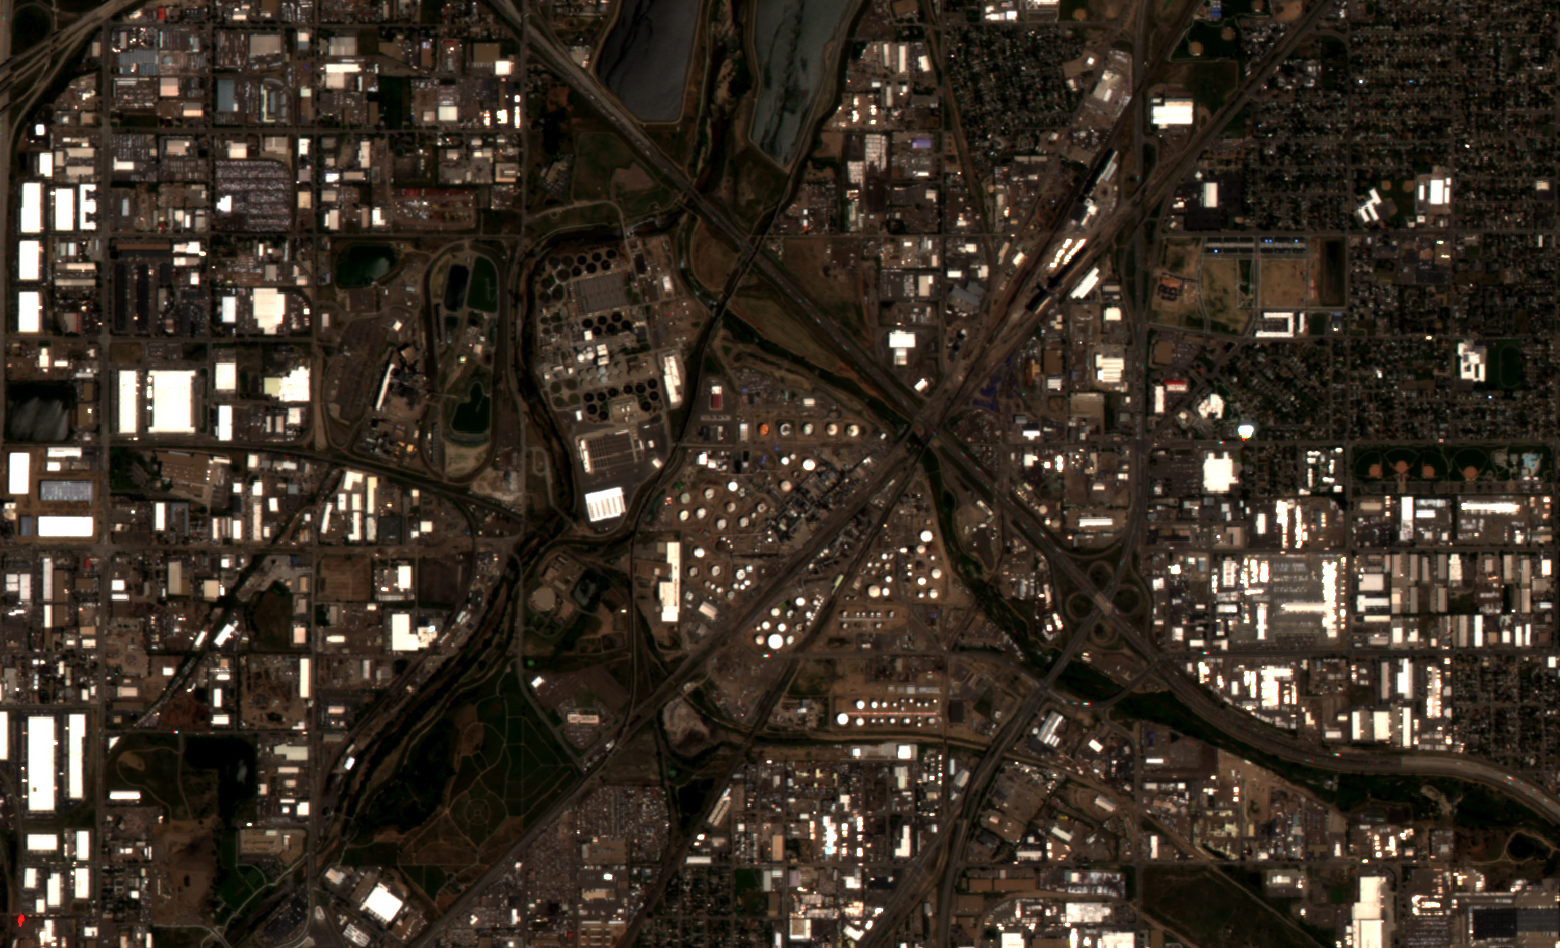

In [15]:
%%time
def normalise_img(x):
    "Scale pixel values to 0-1 range"
    return x / x.max()

def contrast_stretch(img: np.ndarray) -> np.ndarray:
    p2, p98 = np.percentile(img, (2, 98))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


# ds = dataset.isel(time=0)
# dataarray = ds.to_array("band")
dataarray = dataset.to_array("band").sel(band=['red', 'green', 'blue'])  # Assuming the band names are 'red', 'green', 'blue'
# dataarray = ds.to_array("band").sel(band=['nir08', 'green', 'blue'])  # False colour
date = dataarray.time.values
date = pd.to_datetime(date).strftime("%Y-%m-%d")
rgb_numpy_array = np.transpose(dataarray.values, (1, 2, 0))
if SATELLITE == "VENUS":
    rgb_numpy_array = rgb_numpy_array - 1000 # normalise offset
rgb_numpy_array = contrast_stretch(rgb_numpy_array)
rgb_numpy_array = normalise_img(rgb_numpy_array)
rgb_image = Image.fromarray((rgb_numpy_array * 255).astype(np.uint8))
rgb_image.save(OUTPUTS_DIR + f"{SITE}_{date}.png")

rgb_image

Write RGB geotif

In [16]:
# Get CRS and transform from the xarray dataset
crs = "epsg:3857" # dataset.crs
# transform = dataset.transform

# Calculate transform
x_min, y_max = dataset.x.min(), dataset.y.max()
pixel_size_x, pixel_size_y = 5, 5
transform = from_origin(x_min, y_max, pixel_size_x, pixel_size_y)
# print(transform)

# Convert xarray dataset to numpy array and get dimensions
rgb_array = dataset.to_array().values  # Replace this with the correct method if your `dataset` is not directly convertible
height, width, num_bands = rgb_numpy_array.shape


rgb_geotiff = OUTPUTS_DIR + f"{SITE}_{date}_rgb.tiff"

# Open a new GeoTIFF file in write mode
with rasterio.open(
    rgb_geotiff,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=num_bands,
    dtype=rgb_numpy_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    # Write the bands
    for i in range(num_bands):
        dst.write(rgb_numpy_array[:, :, i], i + 1)

print(f"wrote {rgb_geotiff}")

wrote outputs_DENVER_VENUS/DENVER_2023-08-02_rgb.tiff


write multichannel

In [17]:
full_geotiff = OUTPUTS_DIR + f"{SITE}_{date}_ms.tiff"

In [18]:
# Set the CRS and spatial dimensions
dataset = dataset.rio.write_crs("epsg:3857")
dataset = dataset.rio.set_spatial_dims(x_dim="x", y_dim="y")

# Write to GeoTIFF
dataset.rio.to_raster(full_geotiff)
print(f"wrote {full_geotiff}")

wrote outputs_DENVER_VENUS/DENVER_2023-08-02_ms.tiff


## overlay building footprints
We now use building footprints from https://github.com/microsoft/USBuildingFootprints to generate training data. We will train a simple model to classify pixels as belonging to a building or not. Note the file `Colorado.geojson` is large so we have a small version here

In [19]:
# gdf = gpd.read_file("Colorado.geojson")

# minx, miny, maxx, maxy = bbox
# gdf = gdf.cx[minx:maxx, miny:maxy] # Filter out only the polygons within the bounding box
# gdf.head()

In [20]:
gdf = gpd.read_file("denver_roi.geojson")

minx, miny, maxx, maxy = bbox
gdf = gdf.cx[minx:maxx, miny:maxy] # Filter out only the polygons within the bounding box
gdf.head()

,release,capture_dates_range,geometry
0,2,10/3/2018-12/4/2018,"POLYGON ((-104.91274 39.80685, -104.91255 39.8..."
1,2,10/3/2018-12/4/2018,"POLYGON ((-104.91276 39.80909, -104.91260 39.8..."
2,2,10/3/2018-12/4/2018,"POLYGON ((-104.91368 39.79784, -104.91378 39.7..."
3,2,10/3/2018-12/4/2018,"POLYGON ((-104.91373 39.80907, -104.91361 39.8..."
4,2,10/3/2018-12/4/2018,"POLYGON ((-104.91392 39.79731, -104.91392 39.7..."


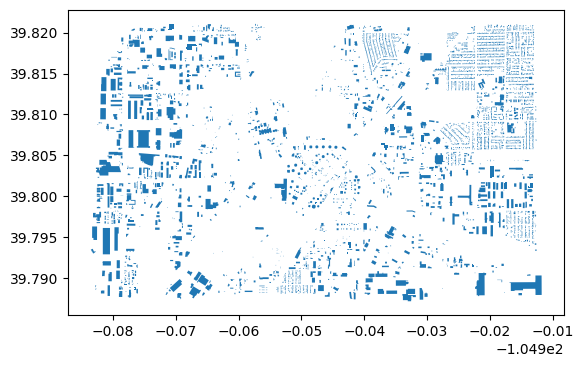

In [21]:
gdf.plot();

Make ML training data from building outlines - experiment with RGB or all bands

In [22]:
# raster_path = rgb_geotiff
raster_path = full_geotiff

raster_path

'outputs_DENVER_VENUS/DENVER_2023-08-02_ms.tiff'

In [23]:
def generate_training_data(raster_path: str, filtered_gdf: GeoDataFrame):
    "Open raster, pixels inside a poly are labelled 1, outside labelled zero"
    with rasterio.open(raster_path) as src:
        # Read all bands
        array = src.read()
        transform = src.transform
        inv_transform = ~src.transform

        # Initialize label array to zeros
        labels = np.zeros(array.shape[1:], dtype=np.uint8)
        filtered_gdf = filtered_gdf.to_crs(epsg=3857) # must match the raster
        print(f"Raster CRS: {src.crs}, Polygon CRS: {filtered_gdf.crs}")  # Debugging line

        for _, row in filtered_gdf.iterrows():
            polygon = row['geometry']
            if polygon is not None:
                # Transform polygon to raster CRS
                poly_transformed = transform_geom(filtered_gdf.crs, src.crs, shape(polygon).__geo_interface__)

                # Rasterize the transformed polygon
                rasterize([(poly_transformed, 1)], out_shape=labels.shape, transform=transform, fill=0, dtype=np.uint8, out=labels)

        print(f"Unique labels after rasterization: {np.unique(labels)}")  # Debugging line

        # Reshape for ML
        array = array.reshape((array.shape[0], -1)).T
        labels = labels.reshape(-1)
        return array, labels


# Generate training data
X, y = generate_training_data(raster_path, gdf)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Raster CRS: EPSG:3857, Polygon CRS: EPSG:3857


Unique labels after rasterization: [0 1]
Shape of X: (1478880, 7)
Shape of y: (1478880,)


Sanity check the generated mask

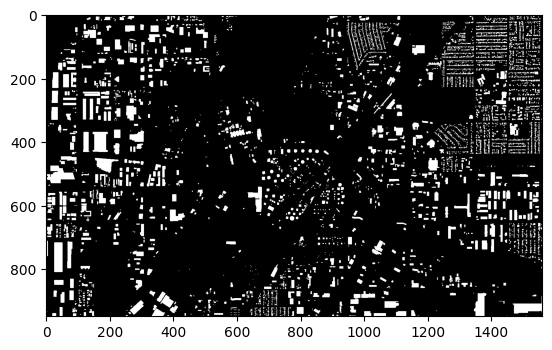

In [24]:
new_shape = (rgb_numpy_array.shape[0], rgb_numpy_array.shape[1])
plt.imshow(y.reshape(new_shape), cmap='Greys_r');

Check for imbalance

In [25]:
def calculate_imbalance(arr):
    # Count zeros and ones
    count_zeros = np.sum(arr == 0)
    count_ones = np.sum(arr == 1)
    
    # Calculate imbalance ratio
    if count_zeros == 0 or count_ones == 0:
        return "Array has only one class, cannot calculate imbalance."
    else:
        imbalance_ratio = max(count_zeros, count_ones) / min(count_zeros, count_ones)
        return imbalance_ratio
    
imbalance = int(calculate_imbalance(y.flatten()))
imbalance

8

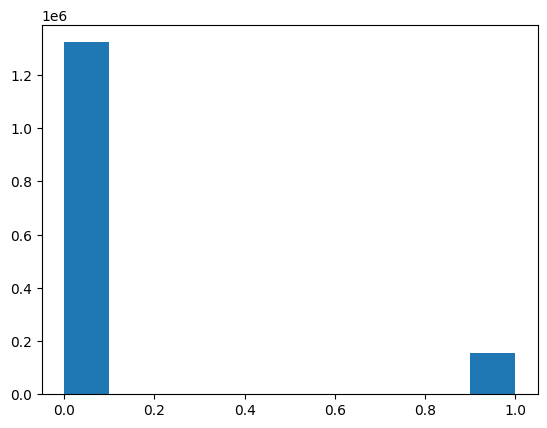

In [26]:
plt.hist(y.flatten());

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Create a Logistic Regression model with class weights
log_reg = LogisticRegression(class_weight={0: 1, 1: imbalance}, random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8582001244184788
              precision    recall  f1-score   support

           0       0.95      0.89      0.92    264557
           1       0.39      0.62      0.48     31219

    accuracy                           0.86    295776
   macro avg       0.67      0.75      0.70    295776
weighted avg       0.89      0.86      0.87    295776



- LR RGB Accuracy: 0.88
- LR MS Accuracy: 0.85

Note random forest takes longer to train but try it you like!

In [30]:
# Create a Random Forest model
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)

# # Validate the model
# y_pred = rf.predict(X_test)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred, target_names=['notbuilding', 'building']))

- RF RGB Accuracy: 0.91
- RF MS Accuracy: 0.95

Now apply this model to another location, try another source for annotationsor improve the model..!